In [19]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn as sns
import pandas as pd
import random
import cv2
import os
import json
import csv

In [2]:
data_path_train = "./data/images/train"
data_path_test = "./data/images/test"

os.makedirs(data_path_train, exist_ok=True)
os.makedirs(data_path_test, exist_ok=True)

## Data preprocessing

In [ ]:
# Load JSON
with open('./data/unsw-predators.json', 'r') as f:
    data = json.load(f)

# Build a dictionary to access annotations through image_id
annotation_map = {
    ann['image_id']: ann['id'].split('#')[0]  # Extract label from annotation 'id'
    for ann in data['annotations']
}

# Create and write to CSV
with open('unsw_predators_labels.csv', 'w', newline='') as csvfile:
    fieldnames = ['file_name', 'width', 'height', 'location', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for img in data['images']:
        label = annotation_map.get(img['id'], 'unknown')  # fallback to 'unknown' if no label
        writer.writerow({
            'file_name': img['file_name'],
            'width': img['training_width'],
            'height': img['training_height'],
            'location': img['location'],
            'label': label
        })

In [ ]:
data_path = "C:/Users/bzh/EFREI/S8/Machine Learning for Data Engineers/project/unsw_predators_labels.csv" # Give the absolute path of your .csv file here

# Import metadata for the wildlife images
data = pd.read_csv(data_path)

# Cleaning data, removing the unused columns, rows with missing info and duplicates
data = data[['file_name', 'width', 'height', 'location', 'label']]
data = data.dropna()
data = data.drop_duplicates()

Goanna = data[data['label'] == 'goanna'].sample(frac=0.7, random_state=42)
indexGoanna = Goanna.index
data.drop(indexGoanna , inplace=True)

while True: # dataset balancing : ensure that the least frequent label is at least half as frequent as the most frequent label
    value_counts = data['label'].value_counts()
    majority_count = value_counts.iloc[0]
    minority_label = value_counts.idxmin()
    minority_count = value_counts.min() # Designate a minority class

    if minority_count * 2 >= majority_count:
        break  # stop when all labels have at least half the size of the majority class

    # Duplicate the minority class
    data_minority = data[data['label'] == minority_label]
    data = pd.concat([data, data_minority], ignore_index=True)

print("Data class distribution:\n", value_counts) # Display metadata
print('Size of the data after cleaning:', data.size)  # Display size of the dataframe

Data class distribution:
 label
goanna    25308
dingo     24540
fox       17684
possum    16592
quoll     16406
Name: count, dtype: int64
Size of the data after cleaning: 502650


In [ ]:
train_data, test_data = train_test_split(data, 
                                         train_size = 0.045, 
                                         test_size=0.0075, 
                                         random_state=64,
                                         shuffle=True
                                        ) # Split data into train and test set

# Display metadata for the train and test set (class distribution)
print("Training set class distribution:\n", train_data['label'].value_counts()) 
print("\nTest set class distribution:\n", test_data['label'].value_counts())

print('\nTrain set size:', train_data.shape, '\nTest set size:', test_data.shape)

Training set class distribution:
 label
dingo     1138
goanna    1082
fox        792
possum     774
quoll      737
Name: count, dtype: int64

Test set class distribution:
 label
goanna    212
dingo     198
fox       118
possum    116
quoll     110
Name: count, dtype: int64

Train set size: (4523, 5) 
Test set size: (754, 5)


## Data download

In [9]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Progress bar

def download_image(row, split):
    label = row['label'].replace(" ", "_")

    img_name = row['file_name']
    base_filename = os.path.basename(img_name)

    # Create the target directory
    target_dir = os.path.join("data/images", split, label)
    os.makedirs(target_dir, exist_ok=True)
    file_path = os.path.join(target_dir, base_filename)

    # Skip if already exists
    if os.path.exists(file_path):
        return f"Skipped (already exists): {file_path}"

    image_url = f"https://storage.googleapis.com/public-datasets-lila/unsw-predators/images/{img_name}"

    try:
        response = requests.get(image_url, timeout=10)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(response.content)
            return f"Downloaded: {file_path}"
        else:
            return f"Failed ({response.status_code}): {image_url}"
    except Exception as e:
        return f"Error: {image_url} - {e}"


# Number of threads to use
max_workers = 16

print("Start downloading training set images with multithreading...")
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = list(tqdm(executor.map(lambda row: download_image(row, "train"), train_data.to_dict('records')), total=len(train_data)))

print("Training set download complete.")


Start downloading training set images with multithreading...


100%|██████████| 4523/4523 [13:33<00:00,  5.56it/s]

Training set download complete.


In [10]:
print("Start downloading test set images with multithreading...")
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = list(tqdm(executor.map(lambda row: download_image(row, "test"), test_data.to_dict('records')), total=len(test_data)))

print("Test set download complete.")

Start downloading test set images with multithreading...


100%|██████████| 754/754 [02:06<00:00,  5.98it/s]

Test set download complete.


## Dataset creation

In [ ]:
# Use data directory paths to generate the train and test datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path_train,
    labels='inferred',
    batch_size=8,
    image_size=(900, 1600)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path_test,
    labels='inferred',
    batch_size=8,
    image_size=(900, 1600)
)

class_names = ['dingo', 'fox', 'goanna',  'possum', 'quoll']
num_classes = len(train_dataset.class_names)

Found 4358 files belonging to 5 classes.
Found 750 files belonging to 5 classes.


In [ ]:
y_train = []

for _, label in train_dataset:
    arr = label.numpy()
    if arr.ndim == 0:
        y_train.append(int(arr))                     # scalar
    elif arr.ndim == 1 and arr.shape[0] == 1:
        y_train.append(int(arr[0]))                  # shape (1,)
    else:
        y_train.append(int(np.argmax(arr)))          # one-hot

y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


In [15]:
factor = 2
resize_height = int(8*9*factor)
resize_width = int(8*16*factor)

print("resize height:", resize_height)
print("resize width:", resize_width)

rescale_and_resize = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255), 
            tf.keras.layers.Resizing(resize_height, resize_width, crop_to_aspect_ratio=True)
    ]) # Rescale the image data

'''
flip = tf.keras.Sequential([
  layers.RandomFlip("horizontal")
])

brightness_and_contrast = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness([0,0.3]),
    tf.keras.layers.RandomContrast([0, 0.3])
])
'''


resize height: 144
resize width: 256


'\nflip = tf.keras.Sequential([\n  layers.RandomFlip("horizontal")\n])\n\nbrightness_and_contrast = tf.keras.Sequential([\n    tf.keras.layers.RandomBrightness([0,0.3]),\n    tf.keras.layers.RandomContrast([0, 0.3])\n])\n'

In [16]:
#train_dataset = train_dataset.map(lambda x, y: (flip_and_rotate(x), y))
#train_dataset = train_dataset.map(lambda x, y: (brightness_and_contrast(x), y))

train_dataset = train_dataset.map(lambda x, y: (rescale_and_resize(x), y)) # Apply the transformation
test_dataset = test_dataset.map(lambda x, y: (rescale_and_resize(x), y)) # Apply the transformation

(8, 144, 256, 3)


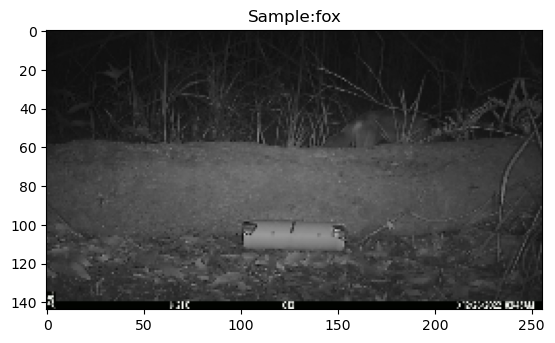

In [17]:
for images, labels in train_dataset.take(1): # Display one image from the dataset along with the associated label
    print(images.shape)
    plt.imshow(images[0].numpy())
    plt.title("Sample:" + class_names[labels[0]])

In [20]:
CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(resize_height, resize_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') 
])

CNN.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 142, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 71, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 71, 127, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 71, 127, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 71, 127, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 33, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 33, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,301 (434.77 KB)

 Trainable params: 110,853 (433.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [89]:
early = EarlyStopping(patience=5, restore_best_weights=True)  # Stop if no improvement in val_loss for 5 epochs
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)         # Reduce LR by half if no improvement in 3 epochs

CNN.fit(
    train_dataset,
    epochs=15,
    batch_size=64,
    validation_data=test_dataset,
    class_weight=class_weights,          # Apply class weights to address imbalance
    callbacks=[early, reduce_lr]         
)

Epoch 1/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 133s 238ms/step - accuracy: 0.4800 - loss: 1.0086 - val_accuracy: 0.4827 - val_loss: 1.1637 - learning_rate: 0.0010
Epoch 2/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 124s 228ms/step - accuracy: 0.5911 - loss: 0.7257 - val_accuracy: 0.4187 - val_loss: 2.4039 - learning_rate: 0.0010
Epoch 3/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 128s 235ms/step - accuracy: 0.6205 - loss: 0.6803 - val_accuracy: 0.6533 - val_loss: 0.7611 - learning_rate: 0.0010
Epoch 4/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 130s 237ms/step - accuracy: 0.6451 - loss: 0.6257 - val_accuracy: 0.6013 - val_loss: 1.0487 - learning_rate: 0.0010
Epoch 5/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 120s 219ms/step - accuracy: 0.6614 - loss: 0.5907 - val_accuracy: 0.5987 - val_loss: 1.2432 - learning_rate: 0.0010
Epoch 6/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 124s 226ms/step - accuracy: 0.6890 - loss: 0.5464 - val_accuracy: 0.5147 - val_loss: 2.7303 - learning_rate: 0.0010
Epoch 7/15
545/545 ━━━━━━━━━━━━━━━━━━━━ 127s 232ms/step - accura

In [ ]:
#CNN.fit(train_dataset, epochs=10, batch_size = 64)

In [90]:
y_test = CNN.evaluate(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9070 - loss: 0.2974 


In [93]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Get true labels in correct order
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

# Step 2: Predict (batched)
y_pred = CNN.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Check shape alignment
print("True:", true_labels.shape)
print("Pred:", y_pred_classes.shape)

# Step 4: Compare and report
print("Classification report with CNN:\n")
print(classification_report(true_labels, y_pred_classes, target_names=class_names))


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step 
True: (750,)
Pred: (750,)
Classification report with CNN:

              precision    recall  f1-score   support

       dingo       0.29      0.28      0.28       198
         fox       0.25      0.25      0.25       116
      goanna       0.28      0.30      0.29       212
      possum       0.20      0.18      0.19       114
       quoll       0.14      0.14      0.14       110

    accuracy                           0.25       750
   macro avg       0.23      0.23      0.23       750
weighted avg       0.24      0.25      0.24       750



In [94]:
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.extend(img_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(images), np.array(labels)

X_test_np, y_test_np = dataset_to_numpy(test_dataset)

y_pred = CNN.predict(X_test_np)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_np, y_pred_classes, target_names=class_names))


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
              precision    recall  f1-score   support

       dingo       0.83      0.82      0.83       198
         fox       0.77      0.76      0.76       116
      goanna       0.93      0.99      0.96       212
      possum       0.97      0.87      0.92       114
       quoll       0.90      0.91      0.90       110

    accuracy                           0.88       750
   macro avg       0.88      0.87      0.87       750
weighted avg       0.88      0.88      0.88       750



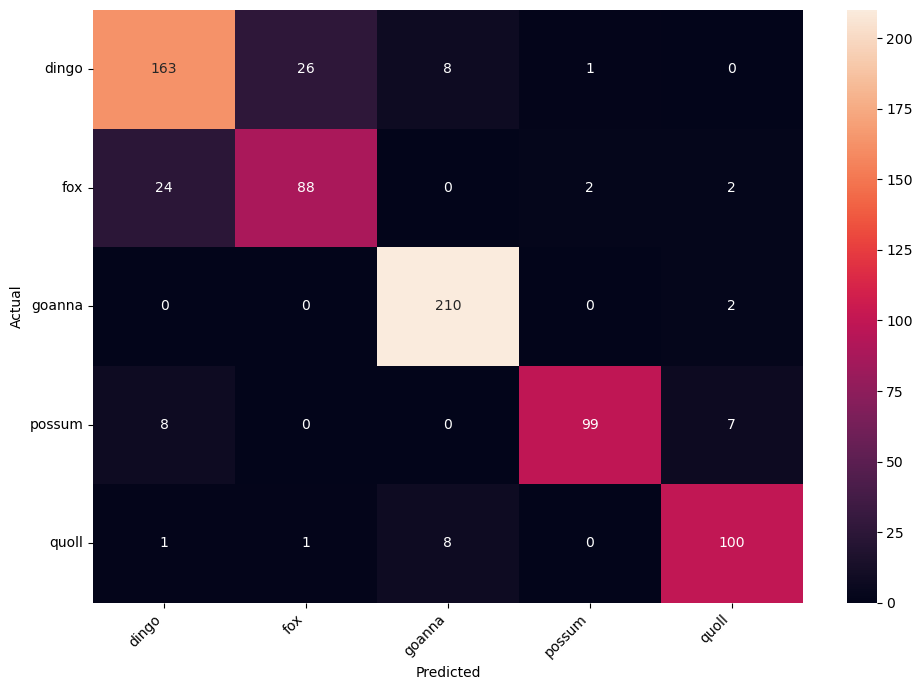

In [99]:
conf_mat = tf.math.confusion_matrix(labels=y_test_np, predictions=y_pred_classes)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt="d")
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()